# Over dit document
In dit document wordt een CRISP-DM cycles doorlopen, welke vervolgens een dataproduct (visualisaties) op zal leveren. Tot slot wordt er een conclusie getrokken en advies gegeven.

Auteur:Eefkje-Femke Jansen van der Sligte

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans, BisectingKMeans
df_original=pd.read_excel("Complete-dataset-FINAL.xlsx")

pd.options.mode.chained_assignment = None  # default='warn'

In [61]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Business Understanding
Het ziekenhuis Isala wil de zorg voor diabetespatiënten verbeteren. Het gaat hier specifiek om het behandelproces door onnauwkeurigheden in metingen te filteren en hierop te baseren of een behandelplan aangepast moet worden of niet. Visualisaties zullen helpen bij het verkrijgen van inzicht van diverse meetmethoden om vervolgens conclusies te kunnen trekken. Die zijn er nog niet. Om meer inzicht te bieden, willen we gaan kijken naar mogelijke relaties die er nog niet zijn. Dit zal worden gedaan door het clusteren van de Europese meetmethoden.


# Data Understanding
Welke databronnen zijn gegeven en in welk formaat: Een excel bestand genaamd: Complete-dataset-FINAL.xlsx

### note
Het excel bestand dat gebruikt gaat worden, is het resultaat van rapporten die om zijn gezet naar excel. Dit is de meest recente versie waarin de meetmethoden zijn genormaliseerd en de waarden dubbelgecheckt zijn.

Hoe groot zijn deze databronnen: 355 kB

-4685 rijen

-12 kolommen

Kolomnamen: Method name, N (no. labs), Mean, Bias, CV, Sample, Reference value, Year, Source, Type, Manufacturer (fabrikant).
- Method name : Naam van het meetmethode
- N	: Aantal deelgenomen labs
- Mean :  Gemiddelde van alle HbA1c waarde
- Bias : Absolute toe- of afname van de hoeveelheid mmol/mol ten opzichte van de werkelijke waarde
- CV : Laat zien wat de spreiding is de metingen
- Sample : Hoeveelste meting in het jaar
- Reference Value : Variabel die is gebaseerd op 95% van de gezonde populatie		
- Year : Welk jaar de meting is gedaan
- Source	: Amerikaanse of Europese data
- Type : Vers of bevroren samples

Datatypes: Object, float en int (jaar) 


In [62]:
df_original.shape

(4688, 12)

In [63]:
df_original.dtypes

Method name             object
N (no. labs)            object
Mean                   float64
Bias                   float64
CV                     float64
Sample                  object
Reference Value        float64
Year                   float64
Source (CAP/EurA1c)     object
Type (Fresh/frozen)     object
Manufacturer            object
Total Error            float64
dtype: object

In [64]:
df_original.isna().sum()


Method name              4
N (no. labs)             4
Mean                    86
Bias                   630
CV                     104
Sample                   4
Reference Value         32
Year                     4
Source (CAP/EurA1c)      4
Type (Fresh/frozen)      4
Manufacturer             4
Total Error              0
dtype: int64

In [65]:
df_original.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Mean,4602.0,7.388795,1.896549,4.60,5.780,7.100,8.7000,19.200
Bias,4058.0,0.073361,0.650975,-6.90,-0.090,0.020,0.1300,6.500
CV,4584.0,2.972033,1.420669,0.50,2.100,2.700,3.5000,17.100
Reference Value,4656.0,7.361971,1.864492,4.92,5.800,7.100,8.6500,13.000
Year,4684.0,2015.568531,4.261448,2006.00,2013.000,2017.000,2019.0000,2021.000
Total Error,4688.0,5.759460,2.978506,0.00,3.976,5.194,6.7955,28.216


In [66]:
df_original.columns

Index(['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total Error'],
      dtype='object')

# Data Preparation

In deze fase zal de dataframe aangepast worden om een clustermodel toe te kunnen passen. 
De volgende vragen zijn als richtlijn gebruikt om de data voor te bereiden:

- Moet er nog een kolom weg?
- Zijn er aanpassingen nodig aan de data voordat we met modelling aan de slag kunnen?
- Moet het nog genormaliseerd worden?
- Zijn er lege velden?

In [67]:
#Scheidt de data en verwijder obect kolommen voor clustering
df_Eur=df_original.loc[df_original['Source (CAP/EurA1c)'] == 'EURA1c']
df_Eur = df_Eur.drop(columns=['N (no. labs)', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)', 'Manufacturer', 'Sample', 'Method name' , 'Total Error' , 'Bias']) # kolomm weggooien
df_Eur.columns 

Index(['Mean', 'CV', 'Reference Value', 'Year'], dtype='object')

In [68]:
df_Eur.isna().sum()

Mean               0
CV                 0
Reference Value    0
Year               0
dtype: int64

Er zijn geen lege waarden te vinden in de dataset.

In [70]:
#omzetten van object kolommen naar float kolommen voor de clustering
df_Eur["Mean"] = df_Eur["Mean"].replace("-", np.nan)
df_Eur["Mean"] = pd.to_numeric(df_Eur["Mean"])

df_Eur["CV"] = df_Eur["CV"].replace("-", np.nan)
df_Eur["CV"] = df_Eur["CV"].replace(" ", np.nan)
df_Eur["CV"] = pd.to_numeric(df_Eur["CV"])

df_Eur.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 73 to 4544
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Mean             514 non-null    float64
 1   CV               514 non-null    float64
 2   Reference Value  514 non-null    float64
 3   Year             514 non-null    float64
dtypes: float64(4)
memory usage: 20.1 KB


## Data analyse
Er is bewust de keuze genomen om voor de model fase de data te inventariseren. Dit is alleen ter observatie en schetst een beeld van de data. Dit zal worden gedaan a.d.h.v. de 8v's. Namelijk Volume, Velocity, Variety, Variability, Varicity, Validity, Volatility en Visualisation.


- Volume: 355 kB, 4685 rijen en 12 kolommen. De volume zal gedurende het project niet veranderen.
- Velocity: het snel verwerken van de data is nu niet van belang. Per jaar wordt er een nieuw rapport gepubliceerd. 
- Variety: de dataset bevat meetmethodes en metingen (denk aan'Method name'). Daarnaast zijn er nog variabelen die de meetmethodes en metingen hebben ondersteund (denk aan 'Reference value'). Tot slot zijn er nog variabelen die een meting uniek maakt (denk aan 'Year' en 'Type').
- Variability: De dataset bevat medische resultaten van metingen. Deze metingen zijn statisch en de betekenis zal niet veranderen. Verder is de structuur van de data afgestemd op een dataformaat.
- Varicity: deze dataset bevat het eindresultaat van het constant valideren en checken van de kwaliteit van de data. Rijen die lege waarden bevatten, zullen niet gelijk worden verwijderd. Het gebruik van die specifieke rijen zullen bepaalt worden bij de data preparation fase.  
- Validity: de gebruikte dataset is het resultaat van gepubliceerde medische rapporten om te zetten naar dataframes. In dat proces zijn waarden absoluut niet aangepast. 
- Volatility: de dataset bevat medische resultaten van metingen. Deze metingen zijn statisch en de betekenis zal niet veranderen.
- Visualisation: voor de visualisatie wordt er een pairplot en heatmap gebruikt.

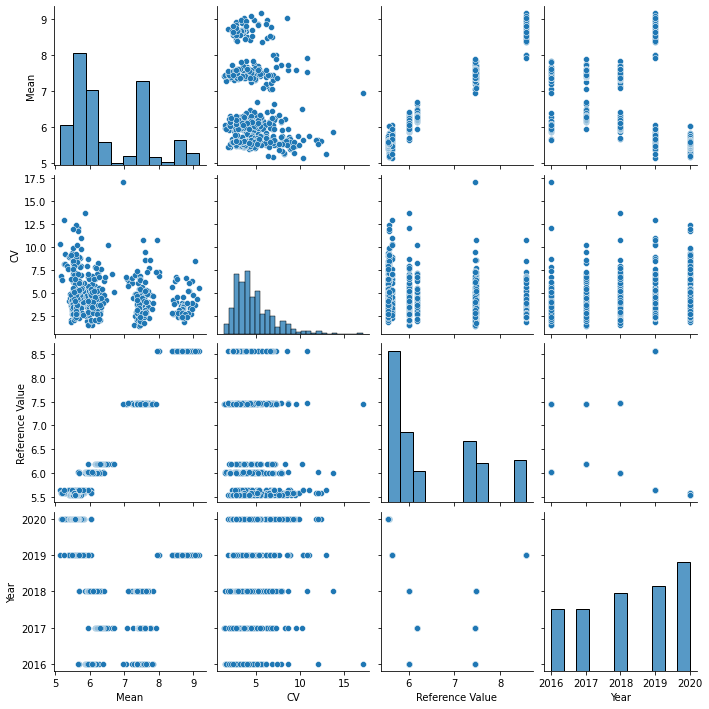

In [71]:
sns.pairplot(df_Eur)

<AxesSubplot:>

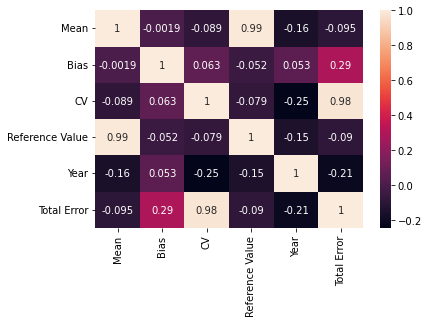

In [73]:
sns.heatmap(df_original.corr(),annot=True)

# Data analyse bevindingen
- In de pairplot is te zien dat de reference value een vast waarde krijgt.
- Bij de 'Mean' en 'Year' is er een range met onderbreking te zien. 
- Er zijn op het oog drie duidelijke groepen te zien bij de 'CV'-waarde en de 'Mean'.
- Er is een hoge correlatie te vinden bij de 'reference value' en 'Mean'. Daarnaast is er nog enigzins een correlatie te vinden bij de 'Bias', 'Total Error' en 'CV'-waarde. Dit is te verklaren doordat bepaalde variabelen gebruikt worden om de andere te berekenen.
- De correlatie van tussen de 'Reference Value' en de 'Mean' is erg hoog, namelijk 1. Note: Bij de clusteranalyse van de Amerikaanse data is er een linear verband te zien tussen de 'Mean' en 'Reference value'. Dat verband is hier niet te zien, maar verklaart de correlatie tussen deze twee variabelen wel. Namelijk dat de 'Mean' wordt gebruikt bij het berekenen van de 'Reference value'.

# Modeling


## Aantal clusters bepalen met een elbow plot

<AxesSubplot:>

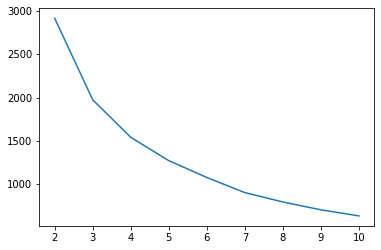

In [74]:
df_model = df_Eur.copy()

n_clusters_to_test = range(2, 11)
inertias = []

for n in n_clusters_to_test:
    model = KMeans(n_clusters=n).fit(df_model)
    inertias.append(model.inertia_)
    
sns.lineplot(x=n_clusters_to_test, y=inertias)

## Eerste model met KMeans
De keuze om het juiste aantal clusters te kiezen, heb ik gebaseerd op het kleinste aantal cluster met de grootste knik. In dit geval is dat bij 3 clusters.


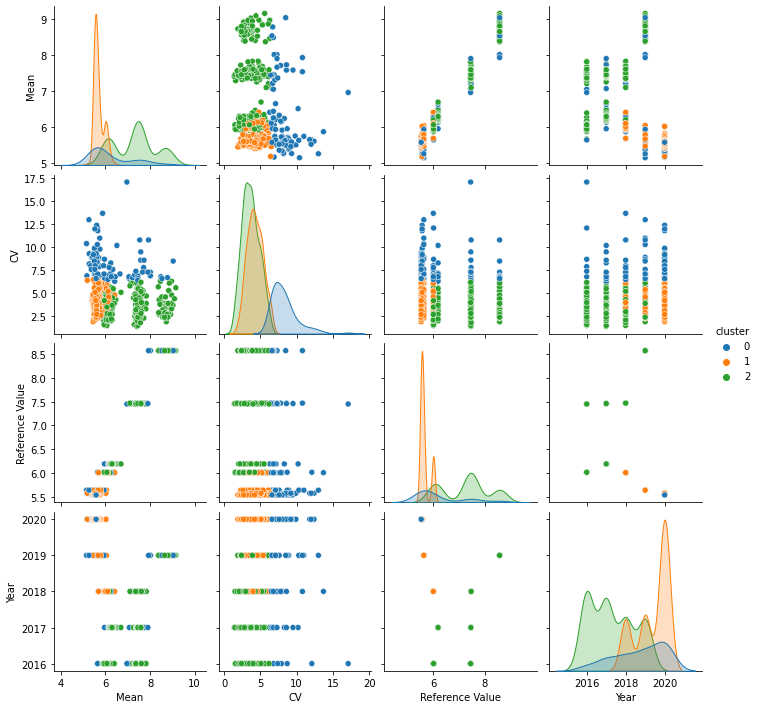

In [75]:
test = pd.DataFrame(columns = ['centroid_x', 'centroid_y'])

model = KMeans(n_clusters=3, random_state=42).fit(df_model)
df_model['cluster'] = model.labels_
df_model['cluster'] = df_model['cluster'].astype('category')
sns.pairplot(df_model, hue='cluster')

# Analyse pair plot
De rechte banden in de onderste rij - rechts overlappen elkaar. Hieruit kan worden geconcludeerd dat de data niet genormaliseerd hoeft te worden.

Opvallende punten bij de clusters:
- Bij cluster 0 is te zien dat de datapunten verspreidt zijn over de diverse jaren. De 'CV'-waarden liggen hier aan de hoge kant. 
- Bij cluster 1 is is de data vooral gefocust op de recentere jaren zoals 2018 en 2020. Hier bij zijn lagere waarden te vinden van de reference value.
- bij cluster 2 is de data vooral gefocust op de eerdere jaren zoals 2016 en 2017. Verder is te zien dat een lage 'CV'-waarde gegroupeerd wordt met hoge 'Mean'-waarden. 


# Cluster analyse

In [76]:
cluster_0 = df_model[df_model['cluster'] == 0]
cluster_1 = df_model[df_model['cluster'] == 1]
cluster_2 = df_model[df_model['cluster'] == 2]
df_model['cluster'].value_counts()

2    236
1    185
0     93
Name: cluster, dtype: int64

<AxesSubplot:xlabel='cluster', ylabel='CV'>

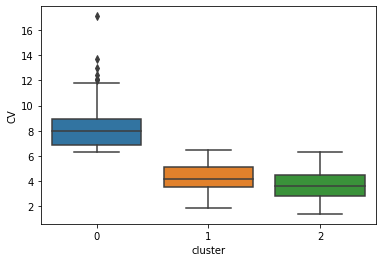

In [77]:
sns.boxplot(x='cluster', y='CV', data=df_model)

<AxesSubplot:xlabel='cluster', ylabel='Mean'>

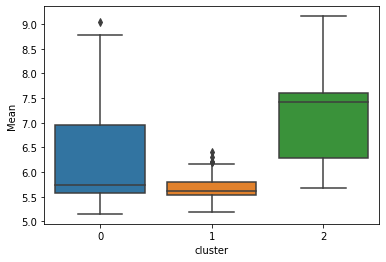

In [78]:
sns.boxplot(x='cluster', y='Mean', data=df_model)

<AxesSubplot:xlabel='cluster', ylabel='Reference Value'>

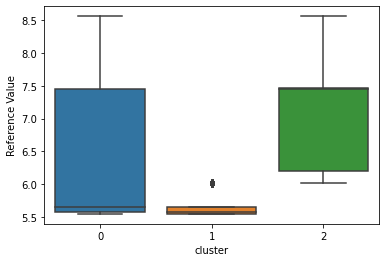

In [79]:
sns.boxplot(x='cluster', y='Reference Value', data=df_model)

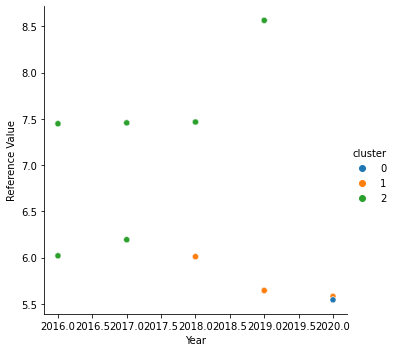

In [80]:
sns.relplot(x='Year', y='Reference Value', hue='cluster', data=df_model)

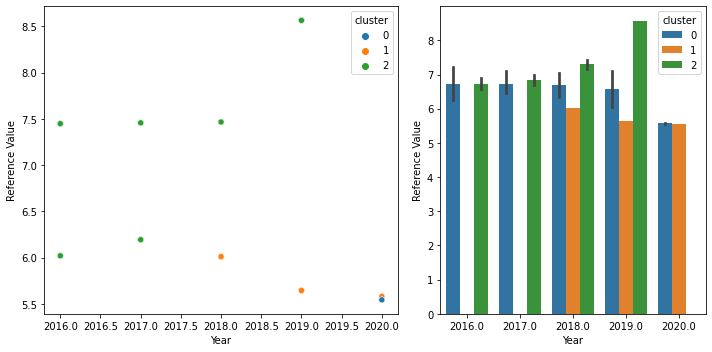

In [81]:
f, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw=dict(width_ratios=[4, 3]))
sns.scatterplot(data=df_model, x='Year', y='Reference Value', hue="cluster", ax=axs[0])
sns.barplot(x='Year', y='Reference Value', data=df_model, hue='cluster', ax=axs[1])
f.tight_layout()

Bij deze scatterplot heeft cluster 2 en cluster 1 duidelijke de meeste datapunten. Wanneer hier meer wordt ingezoomd (barplot rechter visualisatie), is te zien dat cluster 0 juist alle datapunten bevat van de reference value, alleen niet zichtbaar in de scatterplot.

In [82]:
#Add data
df_cluster_0 = pd.DataFrame(columns=['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total Error'])
df_cluster_0 = df_original.loc[cluster_0.index, :]
df_cluster_0['cluster'] = 0
df_cluster_0.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Mean,93.0,6.242313,0.962325,5.15120,5.58125,5.74595,6.96290,9.03995
Bias,93.0,0.084946,2.506424,-6.90000,-0.90000,0.40000,1.60000,5.20000
CV,93.0,8.295699,1.854719,6.30000,6.90000,8.00000,8.90000,17.10000
Reference Value,93.0,6.263269,0.957455,5.54465,5.58125,5.64530,7.44785,8.56415
Year,93.0,2018.688172,1.285187,2016.00000,2018.00000,2019.00000,2020.00000,2020.00000
Total Error,93.0,16.344516,3.932703,7.52400,13.84000,16.35200,18.39600,28.21600
cluster,93.0,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000


In [83]:
df_cluster_1 = pd.DataFrame(columns=['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total Error'])
df_cluster_1 = df_original.loc[cluster_1.index, :]
df_cluster_1['cluster'] = 1
df_cluster_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Mean,185.0,5.688923,0.220032,5.18780,5.53550,5.60870,5.7917,6.4139
Bias,185.0,0.669189,1.311062,-3.50000,-0.10000,0.50000,1.3000,5.9000
CV,185.0,4.261622,1.069227,1.90000,3.50000,4.20000,5.1000,6.5000
Reference Value,185.0,5.668051,0.176030,5.54465,5.54465,5.58125,5.6453,6.0113
Year,185.0,2019.383784,0.799971,2018.00000,2019.00000,2020.00000,2020.0000,2020.0000
Total Error,185.0,9.021968,2.612864,3.32400,7.08400,8.64000,10.8840,16.6800
cluster,185.0,1.000000,0.000000,1.00000,1.00000,1.00000,1.0000,1.0000


In [84]:
df_cluster_2 = pd.DataFrame(columns=['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total Error'])
df_cluster_2 = df_original.loc[cluster_2.index, :]
df_cluster_2['cluster'] = 2
df_cluster_2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Mean,236.0,7.305676,0.931622,5.67275,6.292663,7.42955,7.61255,9.15890
Bias,236.0,0.549153,1.600811,-4.00000,-0.500000,0.40000,1.30000,6.50000
CV,236.0,3.654661,1.150328,1.40000,2.800000,3.60000,4.50000,6.30000
Reference Value,236.0,7.255351,0.892225,6.01130,6.194300,7.45700,7.46615,8.56415
Year,236.0,2017.296610,1.117058,2016.00000,2016.000000,2017.00000,2018.00000,2019.00000
Total Error,236.0,7.712288,2.902977,1.43600,5.787000,7.30600,9.55600,17.47600
cluster,236.0,2.000000,0.000000,2.00000,2.000000,2.00000,2.00000,2.00000


In [85]:
clustered_df= pd.concat([df_cluster_0, df_cluster_1, df_cluster_2], ignore_index=True)

In [86]:
clustered_df.groupby('cluster')['Manufacturer'].value_counts()

cluster  Manufacturer     
0        Abbott               17
         Beckman Coulter      12
         Not specified        11
         Siemens               9
         Bio-Rad               7
         Medinor               6
         Roche Diagnostics     6
         HemoCue               5
         Tosoh                 5
         BioMajesty            4
         Lifotronic            3
         Mindray               2
         Sysmex                2
         Diasys                1
         EKF Diagnostics       1
         Thermo Scientific     1
         Trinity Biotech       1
1        Roche Diagnostics    29
         Sebia                27
         Bio-Rad              23
         Menarini             23
         Tosoh                23
         Siemens              20
         Abbott               14
         Beckman Coulter       7
         Trinity Biotech       6
         Not specified         4
         EKF Diagnostics       2
         Thermo Scientific     2
         Alere  

In [87]:
clustered_df.groupby('cluster')['Type (Fresh/frozen)'].value_counts()

cluster  Type (Fresh/frozen)
0        Frozen                  54
         Fresh                   39
1        Fresh                  111
         Frozen                  74
2        Fresh                  136
         Frozen                 100
Name: Type (Fresh/frozen), dtype: int64

# Evaluation

Tijdens het uitwerken van de clusteranalyse is bij het valideren met de product owner naar voren gekomen dat de Amerikaanse en Europese data niet met elkaar te vergelijken is. Als gevolg heb ik de nieuwe clusteranalyses uitgevoerd waarbij deze data gescheiden van is. 

# Analyse uitwerking van clusters

Bij het clusteren van de Europese data is in de pairplot een goede scheiding te zien tussen de clusters 1 & 2 en cluster 0. In de plot is te zien dat de hoogste CV-waarden zijn verdeeld in cluster 0. Verder is de range van de 'Mean'-waarden door de jaren uiteengelopen om vervolgens in 2020 samengevoegd te worden.

Verdere bevindingen:
- Cluster 0 bevat datapunten vanuit alle jaren. Daarnaast zijn in dit cluster de hogere 'CV'-waarden in verdeeld.
- In cluster 2 zijn de hogere 'Mean'-waarden van eerdere jaren verdeeld.
- In de clusterverdeling is te zien dater er een onderscheidt tussen de eerdere metingen en meer recentere metingen lijkt te zitten. Waarbij cluster 2 oudere metingen bevat en cluster 1 de meest actuele metingen.
- De correlatie tussen de 'Reference value' en 'Mean' is niet duidelijk te zien in de clusterindeling. In cluster 1 (met de meest recente metingen) zijn lagere 'Mean' waarden te vinden en een lagere 'Reference value'.
- De manufacturers zijn gelijkmatig verdeeld tussen de clusters.
- De verhouding van het type tot de clustering lijkt ook in evenwicht te zijn. De grotere clusters bevatten meer 'Frozen' samples dan bij de kleinere cluster.


# Conclusie

Om meer inzicht te bieden, willen we gaan kijken naar mogelijke relaties die er nog niet zijn. Dit is gedaan door middel van het clusteren van de Europese meetmethoden. In de clusteranalyse zijn geen nieuwe relaties gelegd.  


# Advies

In de bevindingen die zijn gedaan, kunnen geen concrete relaties gelegd worden. Hiermee is het advies dan ook om dit model, de gemaakte bevindingen en conclusie als aanleiding te gebruiken voor andere onderzoeken. 


Een vervolgonderzoek zou de invloed van 'Year' op de clustering zijn. 


#### Invloed van 'Year' op de clustering
Bij de clusterindeling is te zien er 3 clusters zijn gevormd. Één met eerdere metingen, één met de meest actuele metingen en de laatste cluster bevat metingen van alle jaren waarbij het lijkt dat de 'CV'-waarde hier aan de hoge kant liggen. Als advies geef ik mee om in een vervolg onderzoek/clusteranalyse te gaan kijken naar de invloed van het 'Year' op de clusterindeling. Hier zou een andere clusterindeling kunnen komen waarbij de focus meer ligt op andere variabelen en daardoor mogelijke andere relaties gelegd kunnen worden.

 